# Land Cover Classification for Washington D.C. using Satellite Imagery and Deep Learning
> * 🔬 Data Science
* 🥠 Deep Learning and pixel-based classification

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction-and-objective" data-toc-modified-id="Introduction-and-objective-1">Introduction and objective</a></span></li><li><span><a href="#Part-1---export-training-data-for-deep-learning" data-toc-modified-id="Part-1---export-training-data-for-deep-learning-2">Part 1 - export training data for deep learning</a></span><ul class="toc-item"><li><span><a href="#Import-ArcGIS-API-for-Python-and-get-connected-to-your-GIS" data-toc-modified-id="Import-ArcGIS-API-for-Python-and-get-connected-to-your-GIS-2.1">Import ArcGIS API for Python and get connected to your GIS</a></span></li><li><span><a href="#Prepare-data-that-will-be-used-for-training-data-export" data-toc-modified-id="Prepare-data-that-will-be-used-for-training-data-export-2.2">Prepare data that will be used for training data export</a></span></li><li><span><a href="#Specify-a-folder-name-in-raster-store-that-will-be-used-to-store-our-training-data" data-toc-modified-id="Specify-a-folder-name-in-raster-store-that-will-be-used-to-store-our-training-data-2.3">Specify a folder name in raster store that will be used to store our training data</a></span></li><li><span><a href="#Export-training-data-using-arcgis.learn" data-toc-modified-id="Export-training-data-using-arcgis.learn-2.4">Export training data using <code>arcgis.learn</code></a></span></li></ul></li><li><span><a href="#Part-2---model-training" data-toc-modified-id="Part-2---model-training-3">Part 2 - model training</a></span><ul class="toc-item"><li><span><a href="#Visualize-training-data" data-toc-modified-id="Visualize-training-data-3.1">Visualize training data</a></span></li><li><span><a href="#Load-model-architecture" data-toc-modified-id="Load-model-architecture-3.2">Load model architecture</a></span></li><li><span><a href="#Train-a-model-through-learning-rate-tuning-and-transfer-learning" data-toc-modified-id="Train-a-model-through-learning-rate-tuning-and-transfer-learning-3.3">Train a model through learning rate tuning and transfer learning</a></span></li><li><span><a href="#Visualize-classification-results-in-validation-set" data-toc-modified-id="Visualize-classification-results-in-validation-set-3.4">Visualize classification results in validation set</a></span></li></ul></li><li><span><a href="#Part-3---deployment-and-inference" data-toc-modified-id="Part-3---deployment-and-inference-4">Part 3 - deployment and inference</a></span><ul class="toc-item"><li><span><a href="#Locate-model-package" data-toc-modified-id="Locate-model-package-4.1">Locate model package</a></span></li><li><span><a href="#Model-inference" data-toc-modified-id="Model-inference-4.2">Model inference</a></span></li></ul></li><li><span><a href="#Visualize-land-cover-classification-on-map" data-toc-modified-id="Visualize-land-cover-classification-on-map-5">Visualize land cover classification on map</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6">Conclusion</a></span></li><li><span><a href="#References" data-toc-modified-id="References-7">References</a></span></li></ul></div>

## Introduction and objective

Land cover classification has been one of the most common tasks in remote sensing as it is the foundation for many global and environmental applications. Traditionally, people have been using algorithms like maximum likelihood classifier, SVM, random forest, and object-based classification. The recent success of AI brings new opportunity to this field. This notebook showcases an end-to-end to land cover classification workflow using ArcGIS API for Python. The workflow consists of three major steps: (1) extract training data, (2) train a deep learning **image segmentation** model, (3) deploy the model for inference and create maps. To better illustrate this process, we will use NAIP imagery and high-resolution labeled data provided by the [Chesapeake Conservancy land cover project](https://chesapeakeconservancy.org/conservation-innovation-center/high-resolution-data/land-cover-data-project/).
<img src="./data/img/intro_kent.png" height="700" width = "700">
<center> Figure 1. A subset of of the labeled data for Kent county, Delaware

## Part 1 - export training data for deep learning

### Import ArcGIS API for Python and get connected to your GIS

In [1]:
from arcgis import GIS

In [2]:
gis = GIS("https://datascienceadv.esri.com/portal", "portaladmin", "Roll.Tide2019")

### Prepare data that will be used for training data export

To export training data, we need a _labeled imagery layer_ that contains the class label for each location, and a _raster input_ that contains all the original pixels and band information. In this land cover classification case, we will be using a subset of the one-meter resolution Washington D.C. dataset as the labeled imagery layer and USA NAIP Imagery: Color Infrared as the raster input.

In [3]:
labels = gis.content.search("KENT_10001_ProjectRaster")[0]
labels

<Item title:"KENT_10001_ProjectRaster" type:Imagery Layer owner:portaladmin>

In [6]:
m = gis.map("Kent county, Delaware")
m

MapView(layout=Layout(height='400px', width='100%'))

In [7]:
m.add_layer(labels)

Now let's retrieve the NAIP image layer.

<Item title:"Interpretació d'imatges (Madur)" type:Web Mapping Application owner:esri_ca>
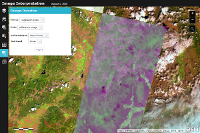

In [13]:
naip_item = gis.content.search("naip", outside_org=True)[0]
naip_item

In [ ]:
from arcgis.raster.functions import extract_band

naiplayer = naip_item.layers[0]
naiplayer

In [ ]:
m.add_layer(naiplayer)

###  Specify a folder name in raster store that will be used to store our training data

Make sure a raster store is ready on your raster analytics image server. This is where where the output subimages, also called chips, labels and metadata files are going to be stored.

In [14]:
from arcgis.raster import analytics

In [15]:
ds = analytics.get_datastores(gis=gis)
ds

<DatastoreManager for https://datascienceadv.esri.com/server/admin>

In [16]:
ds.search()

[<Datastore title:"/nosqlDatabases/AGSDataStore_bigdata_bds_4c9tuc3o" type:"nosql">,
 <Datastore title:"/nosqlDatabases/AGSDataStore_nosqldb_tcs_l6mh5mhm" type:"nosql">,
 <Datastore title:"/enterpriseDatabases/AGSDataStore_ds_b6108wk9" type:"egdb">,
 <Datastore title:"/rasterStores/LocalRasterStore" type:"rasterStore">]

In [17]:
rasterstore = ds.get("/rasterStores/LocalRasterStore")
rasterstore

<Datastore title:"/rasterStores/LocalRasterStore" type:"rasterStore">

In [23]:
samplefolder = "landcover/kent/pro24kent"
samplefolder

'/landcover/kent/pro24kent'

### Export training data using `arcgis.learn`

With the feature class and raster layer, we are now ready to export training data using the export_training_data() method in arcgis.learn module. In addtion to feature class, raster layer, and output folder, we also need to speficy a few other parameters such as tile_size (size of the image chips), strid_size (distance to move in the X when creating the next image chip), chip_format (TIFF, PNG, or JPEG), metadata format (how we are going to store those bounding boxes). More detail can be found [here](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm). 

Depending on the size of your data, tile and stride size, and computing resources, this opertation can take 15mins~2hrs in our experiment. Also, do not re-run it if you already run it once unless you would like to update the setting.

In [ ]:
import arcgis
from arcgis import learn
arcgis.env.verbose = True

In [ ]:
export = learn.export_training_data(input_raster=naiplayer,
                                           output_location=samplefolder,
                                           input_class_data=labels, 
                                           chip_format="PNG", 
                                           tile_size={"x":400,"y":400}, 
                                           stride_size={"x":0,"y":0}, 
                                           metadata_format="Classified_Tiles",                                        
                                           context={"startIndex": 0, "exportAllTiles": False},
                                           gis = gis)

Now let's get into the raster store and look at what has been generated and exported.

In [ ]:
from arcgis.raster.analytics import list_datastore_content

samples = list_datastore_content(rasterstore.datapath + '/' + samplefolder + "/images", filter = "*png")
# print out the first five chips/subimages
samples[0:5]

In [ ]:
labels = list_datastore_content(rasterstore.datapath + '/' + samplefolder + "/labels", filter = "*xml")
# print out the labels/bounding boxes for the first five chips
labels[0:5]

We can also create a image layer using one of this images and look at what it looks like. Note that a chip may or may not have a bounding box in it and one chip might have multiple boxes as well.

## Part 2 - model training

If you've already done part 1, you should already have both the training chips and swimming pool labels. Please change the path to your own export training data folder that contains "images" and "labels" folder.

In [25]:
from arcgis.learn import UnetClassifier, prepare_data

In [26]:
data_path = r'/arcgis/directories/rasterstore/landcover/kent/pro24kent/'

In [ ]:
data = prepare_data(data_path, batch_size=8)

### Visualize training data
To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualize them.

In [ ]:
data.show_batch()

### Load model architecture
We will be using U-net [1], one of the well-recogonized image segmentation algorithm, for our land cover classification. U-Net is designed like an auto-encoder. It has an encoding path (“contracting”) paired with a decoding path (“expanding”) which gives it the “U” shape. However, in contrast to the autoencoder, U-Net predicts a pixelwise segmentation map of the input image rather than classifying the input image as a whole. For each pixel in the original image, it asks the question: “To which class does this pixel belong?”. U-Net passes the feature maps from each level of the contracting path over to the analogous level in the expanding path.  These are similar to residual connections in a ResNet type model, and allow the classifier to consider features at various scales and complexities to make its decision.

<img src="./data/img/unet.png" height="600" width = "600">
<center>Architecture of a Unet model [1]</center>

In [ ]:
model = UnetClassifier(data)

### Train a model through learning rate tuning and transfer learning
[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. Here we explore a range of learning rate to guide us to choose the best one.

In [ ]:
ssd.lr_find()

Based on the learning rate plot above, we can see that the loss starts going down from 1e-4. Therefore, we set learning rate to be a range from 1e-4 to 3e-3, which means we will apply smaller rates to the first few layers and larger rates for the last few layers, and intermediate rates for middle layers, which is the idea of transfer learning. Let's start with 10 epochs for the sake of time.

In [ ]:
ssd.fit(10, lr=slice(1e-5, 1e-4))

### Visualize classification results in validation set
Now we have the model, let's look at how the model performs. Here we plot out 5 rows of images and a threshold of 0.3. Threshold is a measure of probablity that a swimming pool exists. Higher value meas more confidence.

In [ ]:
ssd.show_results(thresh=0.3)

As we can see, with only 10 epochs, we are already seeing reasonable results. Further improvment can be acheived through more sophisticated hyperparameter tuning. Let's save the model for further training or inference later. The model should be saved into a models folder in your folder. By default, it will be saved into your `data_path` that you specified in the very beginning of this notebook.

In [ ]:
ssd.save('5x5-10-deploy')

## Part 3 - deployment and inference

### Locate model package
If you have finished Part 2 of this notebook series, you should have a models folder saved already. The model package is the "5x5-50.zip" zip file in the folder.
The the model package file includes several files:
1. A model definition file with the extension .emd which includes information like model framework (e.g. tensorflow, pytorch). ArcGIS will need it to interpret your model.
2. A model file in binary format that we have developed in Part 2.
3. If your framework is not supported yet, a custom python raster function has to be added as well.
Third, get the deep learning model package file path. _Please change it to your own path_.

In [ ]:
model_package = "Path_To_Your_Model_Package"

In [ ]:
detect_objects_model_package = gis.content.add(item_properties={"type":"Deep Learning Package",
                                                                "typeKeywords":"Deep Learning, Raster",
                                                                "title":"Land_Cover_DC_DL_Model",
                                                                "tags":"deeplearning", 'overwrite':'True'}, 
                                               data=model_package)

In [ ]:
detect_objects_model_package

Now we are ready to install the mode. Installation of the deep learning model item will unpack the model definition file, model file and the inference function script, and copy them to "trusted" location under the Raster Analytic Image Server site's system directory. 

In [ ]:
from arcgis.learn import Model, list_models

In [ ]:
detect_objects_model = Model(detect_objects_model_package)

In [ ]:
detect_objects_model.install()

In [ ]:
detect_objects_model.query_info()

### Model inference
To test our model, let's get a raster image with some swimming pools.

In [ ]:
from arcgis.learn import detect_objects

In [ ]:
out_objects = detect_objects(input_raster=naiplayer.url,
                             model=detect_objects_model,
                             output_name="pooldetection_full_redlands",
                             context={'cellSize': 0.42, 'processorType': 'GPU'},
                             gis=gis)

out_objects

## Visualize land cover classification on map

In [ ]:
result_map = gis.map('Redlands, CA')
result_map.basemap='satellite'
result_map.add_layer(out_objects)
result_map

## Conclusion
In thise notebook, we have covered a lot of ground. In part 1, we discussed how to export training data for deep learning using ArcGIS python API and what the output looks like. In part 2, we demonstrated how to prepare the input data, train a object detection model, visualize the results, as well as apply the model to an unseen image using the deep learning module in ArcGIS API for Python. Then we covered how to install and publish this model and make it production-ready in part 3.

## References
[1] Olaf Ronneberger, Philipp Fischer, Thomas Brox: U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015; <a href='https://arxiv.org/abs/1505.04597'>arXiv:1505.04597</a>.